In [38]:
#imports
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import AUC

from sklearn.metrics import roc_auc_score, f1_score

In [2]:
def csv_to_numpy_with_names(filename: str):
    data = np.genfromtxt(filename, delimiter=',', dtype=np.float64, names=True)
    names = data.dtype.names
    array = data.view((data.dtype[0], len(data.dtype.names)))
    return array, names

In [3]:
#get data from .csv file
train_data, names = csv_to_numpy_with_names("./dataset/exoTrain.csv")
test_data = csv_to_numpy_with_names("./dataset/exoTest.csv")[0]

In [4]:
#data info
print("Column names:")
print(names)
print()
print("=====================================================================================================================")
print()
print("Data:")
print(train_data)
print()
print("=====================================================================================================================")
print()
print("Train shape:")
print(train_data.shape)
print()
print("Test shape:")
print(test_data.shape)

Column names:
('LABEL', 'FLUX1', 'FLUX2', 'FLUX3', 'FLUX4', 'FLUX5', 'FLUX6', 'FLUX7', 'FLUX8', 'FLUX9', 'FLUX10', 'FLUX11', 'FLUX12', 'FLUX13', 'FLUX14', 'FLUX15', 'FLUX16', 'FLUX17', 'FLUX18', 'FLUX19', 'FLUX20', 'FLUX21', 'FLUX22', 'FLUX23', 'FLUX24', 'FLUX25', 'FLUX26', 'FLUX27', 'FLUX28', 'FLUX29', 'FLUX30', 'FLUX31', 'FLUX32', 'FLUX33', 'FLUX34', 'FLUX35', 'FLUX36', 'FLUX37', 'FLUX38', 'FLUX39', 'FLUX40', 'FLUX41', 'FLUX42', 'FLUX43', 'FLUX44', 'FLUX45', 'FLUX46', 'FLUX47', 'FLUX48', 'FLUX49', 'FLUX50', 'FLUX51', 'FLUX52', 'FLUX53', 'FLUX54', 'FLUX55', 'FLUX56', 'FLUX57', 'FLUX58', 'FLUX59', 'FLUX60', 'FLUX61', 'FLUX62', 'FLUX63', 'FLUX64', 'FLUX65', 'FLUX66', 'FLUX67', 'FLUX68', 'FLUX69', 'FLUX70', 'FLUX71', 'FLUX72', 'FLUX73', 'FLUX74', 'FLUX75', 'FLUX76', 'FLUX77', 'FLUX78', 'FLUX79', 'FLUX80', 'FLUX81', 'FLUX82', 'FLUX83', 'FLUX84', 'FLUX85', 'FLUX86', 'FLUX87', 'FLUX88', 'FLUX89', 'FLUX90', 'FLUX91', 'FLUX92', 'FLUX93', 'FLUX94', 'FLUX95', 'FLUX96', 'FLUX97', 'FLUX98', 'FLUX

In [5]:
#get labels
X_train, y_train = np.delete(train_data, 0, axis=1), np.take(train_data, 0, axis=1).astype(int)
X_test, y_test = np.delete(test_data, 0, axis=1), np.take(test_data, 0, axis=1).astype(int)

In [6]:
#check if dataset is unbalanced...
print(np.unique(y_train, return_counts=True))
#...and it is.... :c

(array([1, 2]), array([5050,   37]))


In [7]:
#indexes of data that detects planets
planet_indexes = np.where(y_train == 2)[0]

print("Planet indexes:", planet_indexes)

Planet indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]


In [8]:
#oversampling
n_over = 5000
X_over = np.array([X_train[ind] for ind in np.random.choice(planet_indexes, n_over)])
y_over = np.array([2 for _ in range(n_over)])

In [9]:
#concatenate original data with oversampled data
X_train, y_train = np.concatenate((X_train, X_over)), np.concatenate((y_train, y_over))

In [10]:
#shuffle new datasets
permutation = np.random.permutation(len(y_train))
X_train, y_train = X_train[permutation], y_train[permutation]

In [11]:
#check if dataset is unbalanced...
print(np.unique(y_train, return_counts=True))
#...and it is not c:

(array([1, 2]), array([5050, 5037]))


In [12]:
def show_charts(X, y, indexes, show_labels=False):
    fig, axes = plt.subplots(1, len(indexes), figsize=(20, 5)) 
    for i in range(len(indexes)):
        index = indexes[i]
        axes[i].plot(X[index])
        axes[i].set_title(f"Label: {y[index]} {"(Planet(s) probably exists)" if y[index] > 0 and show_labels else "(No planets)" if show_labels else ""}")
        # print(f"Label: {y[index]} {"(Planet(s) probably exists)" if y[index] > 0 and show_labels else "(No planets)" if show_labels else ""}")
    plt.show()

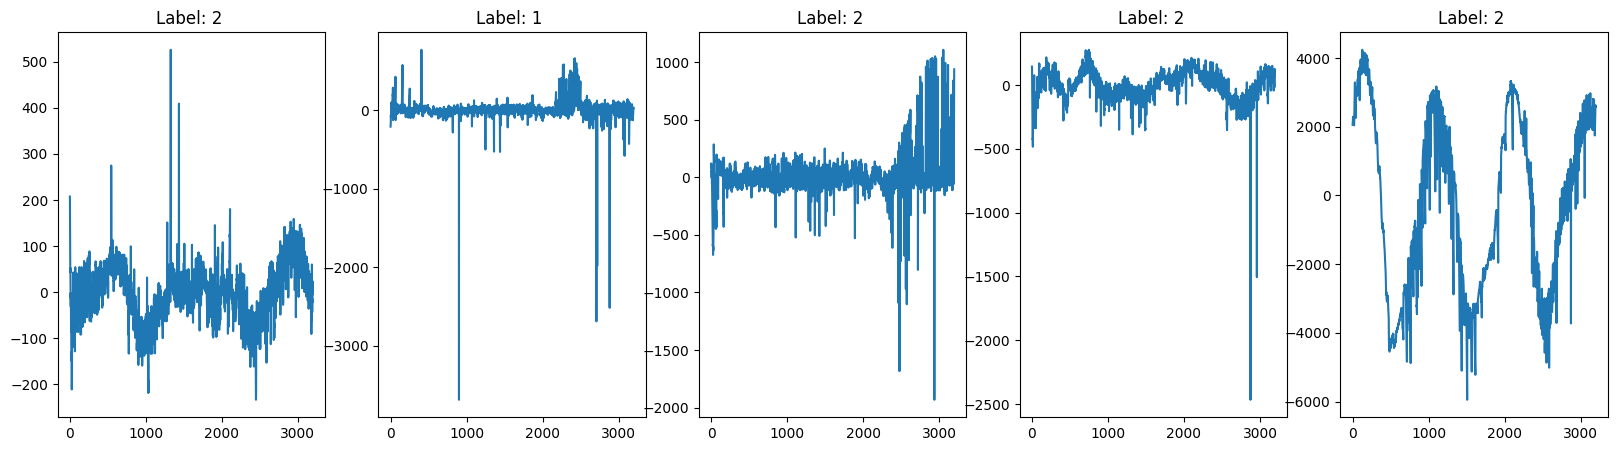

In [13]:
#charts
chart_indexes = [np.random.randint(0, 10000) for _ in range(5)]
show_charts(X_train, y_train, chart_indexes)

In [14]:
def remove_outliers(X_data):
    X = np.empty(X_data.shape)
    for i in range(len(X_data)):
        q1 = np.percentile(X_data[i], 25)
        q3 = np.percentile(X_data[i], 75)
        iqr = q3 - q1

        min_val = q1 - 1.5 * iqr
        max_val = q3 + 1.5 * iqr

        for j in range(1, len(X_data[i])-1):
            if X_data[i][j] < min_val or X_data[i][j] > max_val:
                # X[i][j] = (X_data[i][j-1] + X_data[i][j+1]) / 2
                X[i][j] = X_data[i][j-1]
            else:
                X[i][j] = X_data[i][j]
    return X
    
def normalize_01(data):
    min_val = min(data)
    max_val = max(data)
    d = max_val - min_val
    return (data - min_val) / d

def normalize_X_01(X_data):
    X = np.empty(X_data.shape)
    for i in range(len(X_data)):
        X[i] = normalize_01(X_data[i])
    return X

def prepare_X_data(X_data):
    X = remove_outliers(X_data)
    X = normalize_X_01(X)
    return X
    

In [15]:
#preparing data
X_train, y_train = prepare_X_data(X_train), normalize_01(y_train).astype(int)
X_test, y_test = prepare_X_data(X_test), normalize_01(y_test).astype(int)

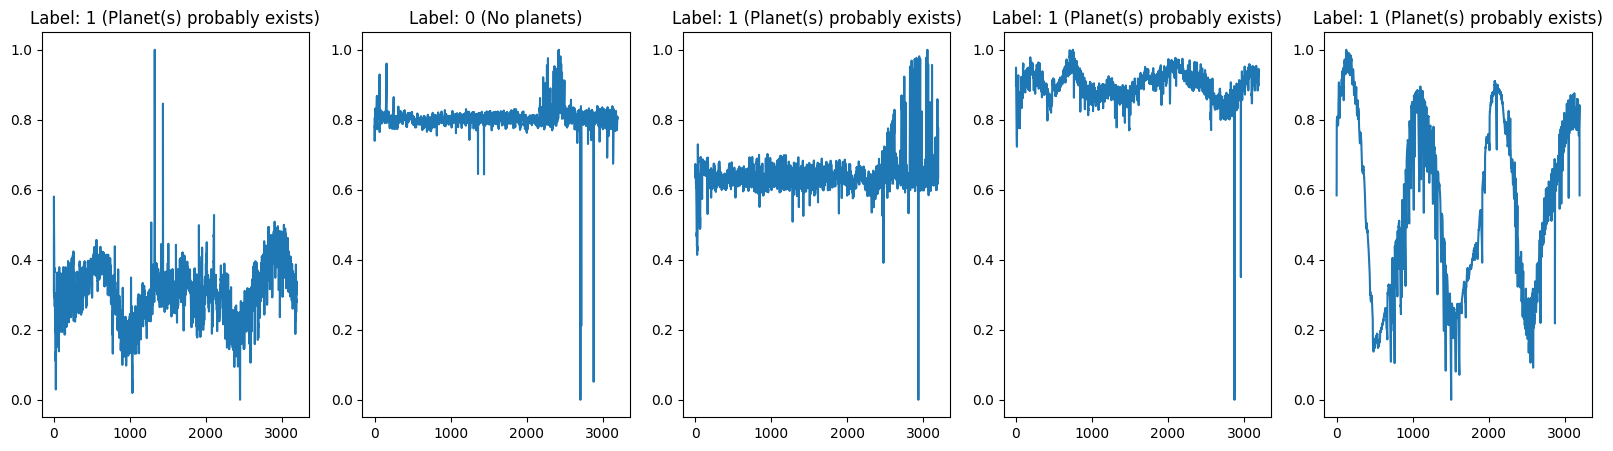

In [16]:
#charts
show_charts(X_train, y_train, chart_indexes, show_labels=True)

In [17]:
#increase data size 2x
X_train, y_train = np.concatenate((X_train, X_train)), np.concatenate((y_train, y_train))
print(X_train.shape)

(20174, 3197)


In [19]:
#define model
n1 = 2000
n2 = 1000
n3 = 500
n4 = 200
n5 = 100

model = Sequential()
model.add(Dense(n1, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(n2, activation='relu'))
model.add(Dense(n3, activation='relu'))
model.add(Dense(n4, activation='relu'))
model.add(Dense(n5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/home/filipjedrzejewski/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
#model compilation
model.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0),
             metrics=['accuracy', AUC()])

In [40]:
#training
model.fit(X_train, y_train, epochs=25, batch_size=400)

Epoch 1/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.6600 - auc: 0.7404 - loss: 1.2426
Epoch 2/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.9583 - auc: 0.9784 - loss: 0.1422
Epoch 3/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.9617 - auc: 0.9792 - loss: 0.1380
Epoch 4/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.9705 - auc: 0.9830 - loss: 0.1144
Epoch 5/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step - accuracy: 0.9729 - auc: 0.9840 - loss: 0.1040
Epoch 6/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 0.8274 - auc: 0.9134 - loss: 0.3735
Epoch 7/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.9635 - auc: 0.9831 - loss: 0.1265
Epoch 8/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - accuracy: 0.9423 - auc: 0.9711 - loss: 0.1943
Epoch 9/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.9763 - auc: 0.9854 - loss: 0.0973
Epoch 10/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.9493 - auc: 0.9780 - loss: 

In [26]:
#increase test data size - oversampling - for better test quality
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([565,   5]))


In [27]:
n_over = 550
planet_test_indexes = planet_indexes = np.where(y_test == 1)[0]
X_test_over = np.array([X_test[ind] for ind in np.random.choice(planet_test_indexes, n_over)])
y_test_over = np.array([1 for _ in range(n_over)])

In [28]:
X_test, y_test = np.concatenate((X_test, X_test_over)), np.concatenate((y_test, y_test_over))

In [29]:
#tests
loss, accuracy = model.evaluate(X_test, y_test)

print("Loss:", loss)
print("Accuracy:", accuracy)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7969 - loss: 1.0088
Loss: 2.624636173248291
Accuracy: 0.49196428060531616


In [30]:
y_pred = model.predict(X_test)
classes_pred = np.array([1 if prediction >= 0.5 else 0 for prediction in y_pred])

print(classes_pred)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[0 0 0 ... 0 0 0]


In [31]:
#confusion matrix
con_matrix = tf.math.confusion_matrix(labels=y_test, predictions=classes_pred)
print(con_matrix)

tf.Tensor(
[[551  14]
 [555   0]], shape=(2, 2), dtype=int32)


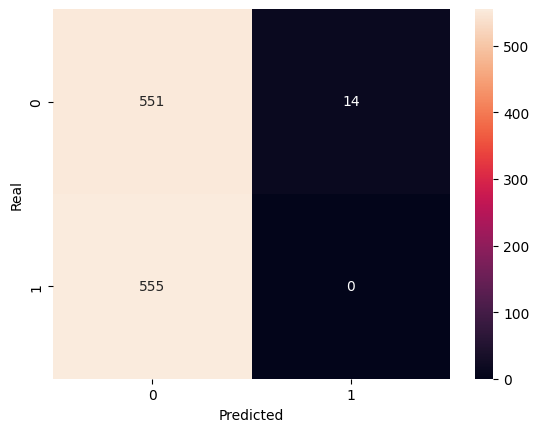

In [32]:
#show confusion matrix
plt.figure()
sns.heatmap(con_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()

In [36]:
#AUC
auc = roc_auc_score(y_test, classes_pred)
print("AUC:", auc)

AUC: 0.48761061946902656


In [37]:
#F1
f1 = f1_score(y_test, classes_pred)
print("F1:", f1)

F1: 0.0
